# Load Kedro

In [183]:
%reload_ext kedro.ipython

[10/13/25 22:25:50] INFO     Registered line magic '%reload_kedro'                                   ]8;id=576220;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=153171;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py#63\63]8;;\

                    INFO     Registered line magic '%load_node'                                      ]8;id=329492;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=526435;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py#65\65]8;;\

                    INFO     Resolved project path as:                                              ]8;id=80831;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=110042;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py#180\180]8;;\
                             /Users/eoinmolloy/Documents/Documents/FPL-Modelling/fpl-modelling.                    
                             To set a different path, run '%reload_kedro <project_root>'                           

                    INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=359491;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro_telemetry/plugin.py\plugin.py]8;;\:]8;id=333901;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro_telemetry/plugin.py#243\243]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[10/13/25 22:25:51] INFO     Kedro project fpl_modelling                                            ]8;id=667358;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=64587;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py#146\146]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=642014;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=815395;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/ipython/__init__.py#147\147]8;;\
                             'pipelines'                                                                           

# Imports

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import f_oneway

# Load data

In [185]:
all_df = catalog.load("players_hist_merged")
all_df.head()

                    INFO     Loading data from players_hist_merged (SQLQueryDataset)...        ]8;id=619385;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=450106;file:///Users/eoinmolloy/Documents/Documents/FPL-Modelling/.venv/lib/python3.12/site-packages/kedro/io/data_catalog.py#1046\1046]8;;\

,player_name,ict_index,round_points,opponent_team_id,opponent_team,was_home,team_a_score,team_h_score,round,round_minutes,...,total_minutes,players_team,players_team_strength,players_team_strength_home,players_team_strength_away,opponent_team_strength,opponent_team_strength_home,opponent_team_strength_away,position_name,position_name_abbr
0,David Raya Martín,4.9,10,14,Man Utd,0,1,0,1,90,...,630,Arsenal,4,1320,1325,3,1105,1125,Goalkeeper,GKP
1,David Raya Martín,1.3,6,11,Leeds,1,0,5,2,90,...,630,Arsenal,4,1320,1325,2,1050,1075,Goalkeeper,GKP
2,David Raya Martín,3.0,2,12,Liverpool,0,0,1,3,90,...,630,Arsenal,4,1320,1325,5,1335,1355,Goalkeeper,GKP
3,David Raya Martín,1.3,6,16,Nott'm Forest,1,0,3,4,90,...,630,Arsenal,4,1320,1325,3,1165,1205,Goalkeeper,GKP
4,David Raya Martín,2.1,2,13,Man City,1,1,1,5,90,...,630,Arsenal,4,1320,1325,4,1275,1315,Goalkeeper,GKP


Data Transformations at start

In [186]:
# Shift round points as we need to predict next round using previous round to avoid data leakage
shift_to_next_week_cols = [
    'round_points',
    'opponent_team',
    'was_home'
]
for shift_to_next_week_col in shift_to_next_week_cols:

    all_df[f"next_week_{shift_to_next_week_col}"] = all_df.groupby('player_id')[shift_to_next_week_col].shift(-1)

all_df['accumulated_minutes'] = all_df.groupby('player_id')['round_minutes'].cumsum()

# all_df['fixture_difficulty'] = np.where(
#     all_df['was_home'] == 1,
#     all_df['players_team_strength_home'] - all_df['opponent_team_strength_away'],
#     all_df['players_team_strength_away'] - all_df['opponent_team_strength_home']
# )

# next_gw_cols = [
#     'players_team_strength',
#     'players_team_strength_home',
#     'players_team_strength_away',
#     'opponent_team_strength',
#     'opponent_team_strength_home',
#     'opponent_team_strength_away',
#     'fixture_difficulty'
# ]

# shift them -1 within each player to align next GW features with current GW
# for col in next_gw_cols:
#     all_df[f'next_{col}'] = all_df.groupby('player_id')[col].shift(-1)


# EDA

##  Play time of Players

Get dataframe of unique players

In [187]:
p_unique_df_all = all_df.drop_duplicates(subset='player_id', keep='last')

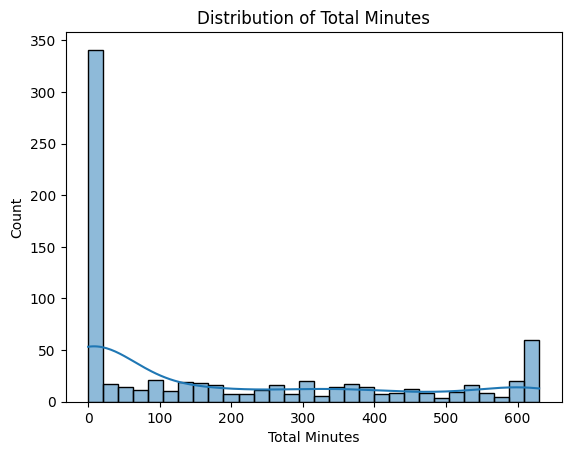

In [188]:


sns.histplot(p_unique_df_all['total_minutes'], bins=30, kde=True)
plt.title('Distribution of Total Minutes')
plt.xlabel('Total Minutes')
plt.ylabel('Count')
plt.show()


Most players havent played any minute giving a right skewed distribution, and there is a spike around 600 minutes for players who have played in most games

### Remove any player who hasnt played a game

In [ ]:
num_all_players = all_df['player_id'].nunique()
num_players_no_mins = all_df.loc[all_df['total_minutes'] > 0, 'player_id'].nunique()
print(f'Removing {num_players_no_mins} from {num_all_players} total players leaving {num_all_players-num_players_no_mins} players left')
    df = all_df[all_df['total_minutes']>0]

model_df = all_df.dropna(subset='next_week_round_points')



Removing 429 from 743 total players leaving 314 players left


In [190]:
p_unique_df = df.drop_duplicates(subset='player_id', keep='last')

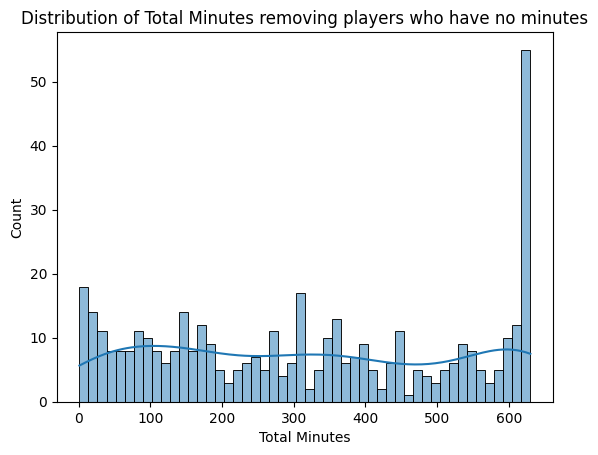

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(p_unique_df['total_minutes'], bins=50, kde=True)
plt.title('Distribution of Total Minutes removing players who have no minutes')
plt.xlabel('Total Minutes')
plt.ylabel('Count')
plt.show()


Now we see the more prominent spike of players who have played most minutes in games giving a left skewed distribution

## Target Variable Univariate Analysis: Total Points

### Distribution

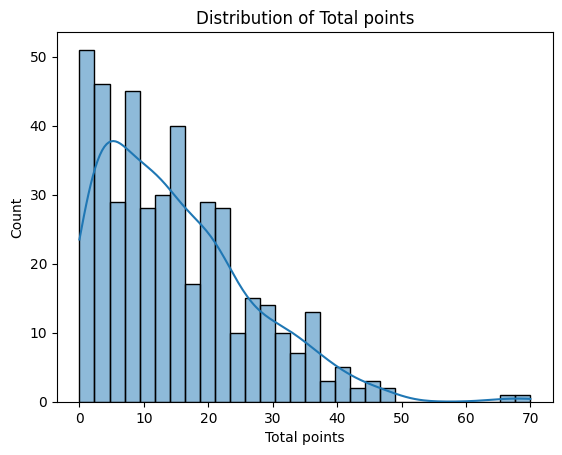

In [192]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(p_unique_df['total_points'], bins=30, kde=True)
plt.title('Distribution of Total points')
plt.xlabel('Total points')
plt.ylabel('Count')
plt.show()


- Total points is also a right skewed distribution with most players not having many points
- we can try a log transformation to see if this will result in a normal distribution

                    WARNING  /var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_97657/10166 ]8;id=822377;file:///opt/homebrew/Cellar/python@3.12/3.12.11_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=363134;file:///opt/homebrew/Cellar/python@3.12/3.12.11_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/warnings.py#112\112]8;;\
                             03022.py:1: SettingWithCopyWarning:                                                   
                                                                                                                   
                                                                                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                                                                                                                   
                                                                                                                   

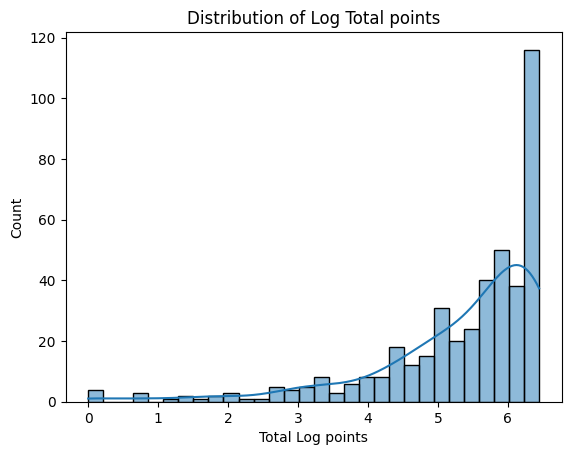

In [193]:
p_unique_df['log_total_minutes'] = np.log(p_unique_df['total_minutes'])

sns.histplot(p_unique_df['log_total_minutes'], bins=30, kde=True)
plt.title('Distribution of Log Total points')
plt.xlabel('Total Log points')
plt.ylabel('Count')
plt.show()


A log transformation actually gives a left skewed distribution instead so it may not be too useful

                    WARNING  /var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_97657/19536 ]8;id=166409;file:///opt/homebrew/Cellar/python@3.12/3.12.11_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=220058;file:///opt/homebrew/Cellar/python@3.12/3.12.11_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/warnings.py#112\112]8;;\
                             93017.py:4: SettingWithCopyWarning:                                                   
                                                                                                                   
                                                                                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                                                                                                                   
                                                                                                                   

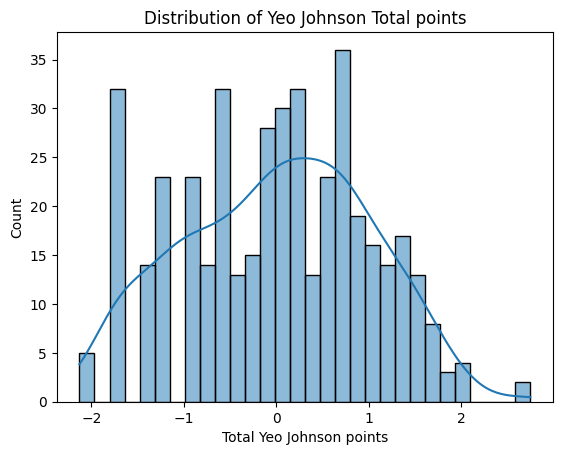

In [194]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
p_unique_df['yj_total_minutes'] = pt.fit_transform(p_unique_df[['total_points']])

sns.histplot(p_unique_df['yj_total_minutes'], bins=30, kde=True)
plt.title('Distribution of Yeo Johnson Total points')
plt.xlabel('Total Yeo Johnson points')
plt.ylabel('Count')
plt.show()

### Outliers

In [195]:
import plotly.express as px

def plot_box_with_hover(df, col, id_col='player_id'):
    fig = px.box(
        df,
        y=col,
        points="outliers",               # show only outliers
        hover_data=[id_col]              # show player_id on hover
    )
    fig.update_layout(
        title=f"Boxplot of {col} with Outliers Hover Info",
        yaxis_title=col,
        xaxis_title=""
    )
    fig.show()


In [196]:
plot_box_with_hover(p_unique_df, col='total_points', id_col='player_name')


## Bivariate Analysis of Round Points

### Numerical Features

#### Correlation Matrix

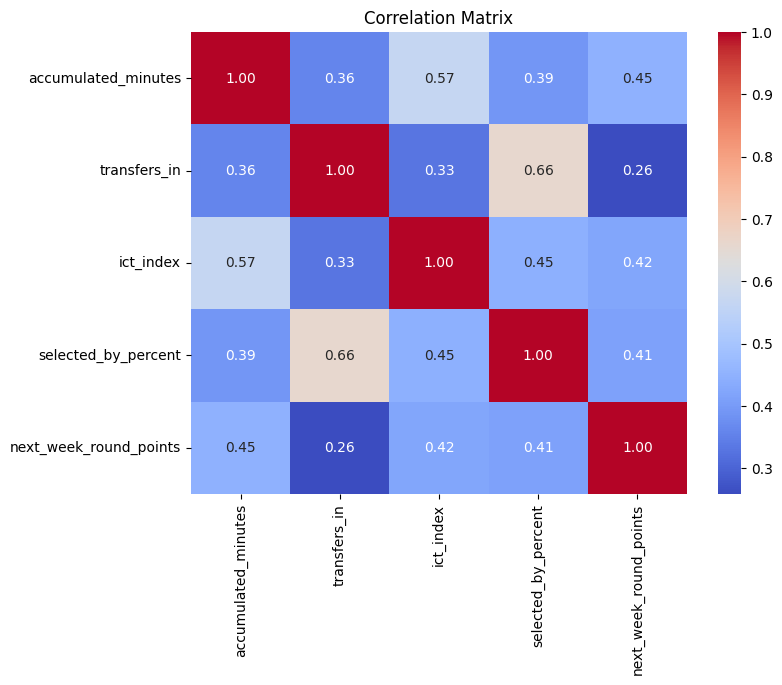

In [197]:
numerical_feature_cols = [
    'accumulated_minutes',
    'transfers_in',
    'ict_index',
    'selected_by_percent'
]
target_col = 'next_week_round_points'

# Select relevant columns
corr_df = model_df[numerical_feature_cols + [target_col]]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()


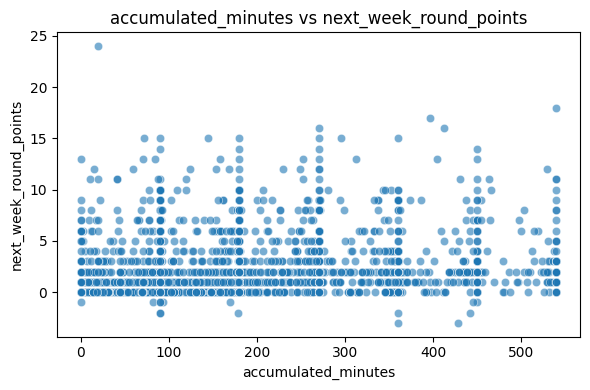

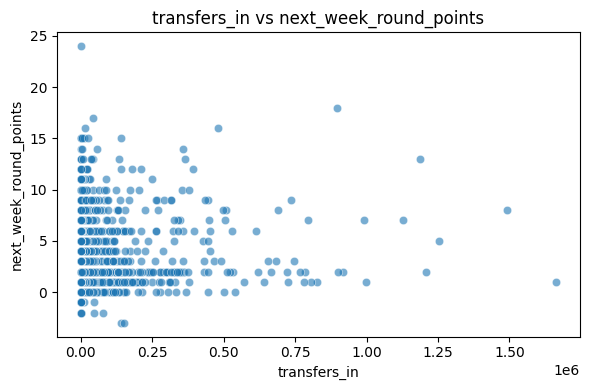

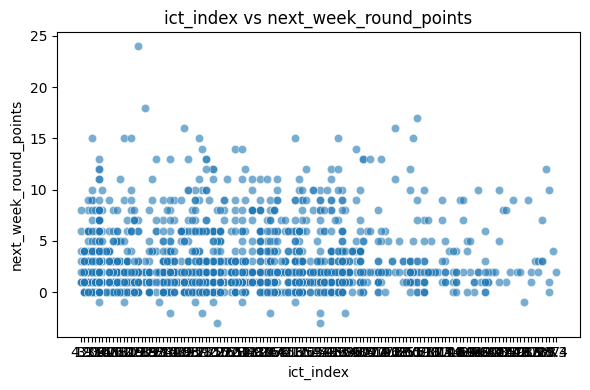

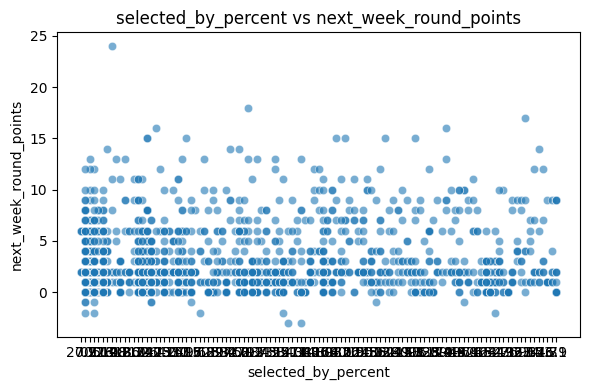

In [198]:
for feature in numerical_feature_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=feature, y=target_col, data=model_df, alpha=0.6)
    plt.title(f"{feature} vs {target_col}")
    plt.xlabel(feature)
    plt.ylabel(target_col)
    plt.tight_layout()
    plt.show()

### Categorial Features

In [199]:
categorical_feature_cols = [
    'next_week_was_home',
    'players_team',
    'next_week_opponent_team',
    'position_name',
]
target_col = 'next_week_round_points'


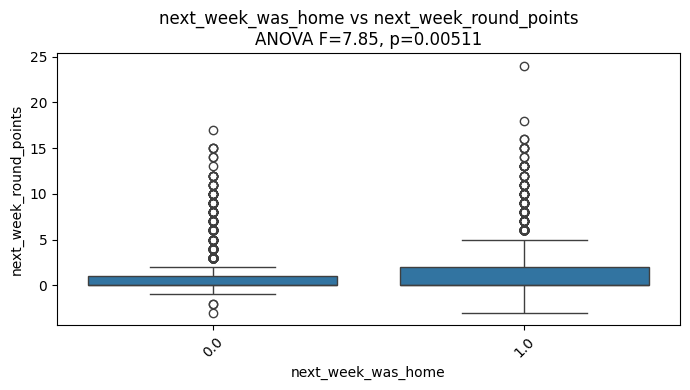

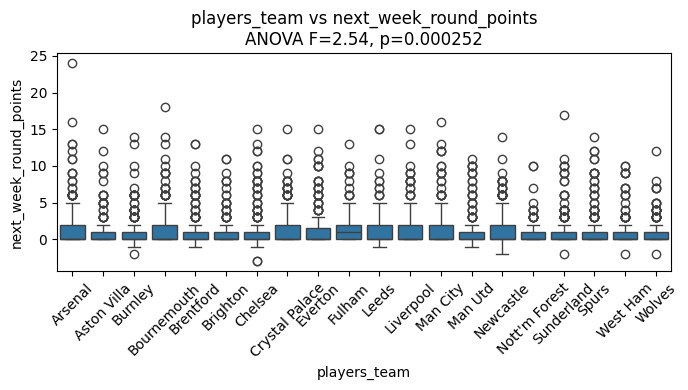

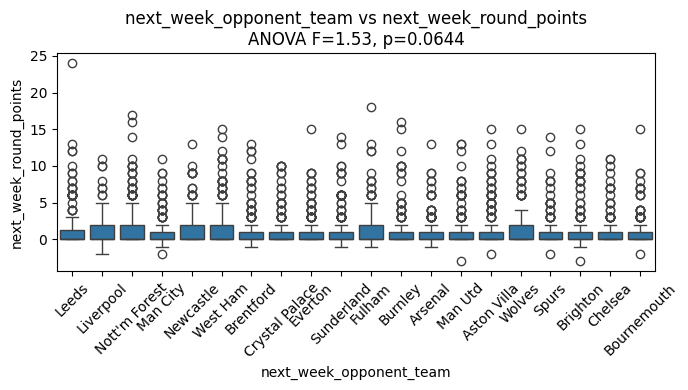

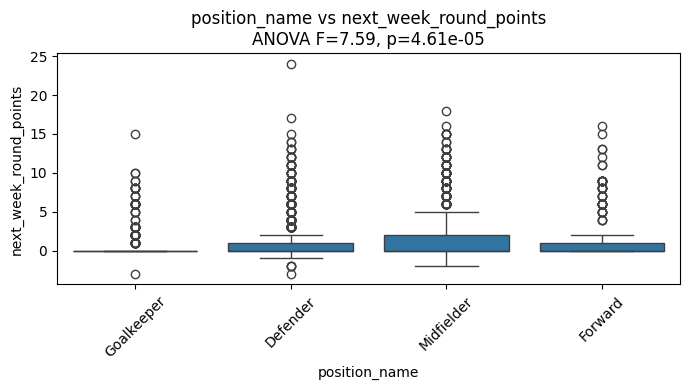

,feature,F_value,p_value
0,next_week_was_home,7.847887,0.005111
3,position_name,7.593823,0.000046
1,players_team,2.538545,0.000252
2,next_week_opponent_team,1.533698,0.064437


In [200]:
anova_results = []

for col in categorical_feature_cols:
    # --- ANOVA test ---
    groups = [model_df[model_df[col] == cat][target_col] for cat in model_df[col].unique()]
    f_val, p_val = f_oneway(*groups)
    anova_results.append({'feature': col, 'F_value': f_val, 'p_value': p_val})

    # --- Boxplot ---
    plt.figure(figsize=(7, 4))
    sns.boxplot(x=col, y=target_col, data=model_df)
    plt.title(f"{col} vs {target_col}\nANOVA F={f_val:.2f}, p={p_val:.3g}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

anova_df = pd.DataFrame(anova_results).sort_values('F_value', ascending=False)
anova_df

All features accept next week opponent team prove statistically singificant difference at > 99% confidence while next week opponent team proves at >90% confidence

# Modelling

## Prepare Train and Test Dataframes

In [201]:
print(f'We have up to gameweek {model_df['round'].max()+1} available which means we can use up to gameweek {model_df['round'].max()-2} for modelling')

We have up to gameweek 7 available which means we can use up to gameweek 4 for modelling


In [202]:
def prepare_df_at_gameweek(current_gameweek, arg_df, num_forecasted_games=3, 
                           target_col='next_week_round_points', num_test_gameweeks=1):
    """
    Build a dataset for a given gameweek, using features from each past gameweek to predict
    total points over the next `num_forecasted_games` gameweeks.

    The most recent `num_test_gameweeks` will be returned as test set, rest as training set.

    Returns:
        train_df, test_df
    """

    max_gw_in_data = arg_df['round'].max()+1

    # --- Sanity checks ---
    if current_gameweek > max_gw_in_data:
        raise ValueError(f"current_gameweek={current_gameweek} is beyond max round in data ({max_gw_in_data}).")

    if current_gameweek + num_forecasted_games > max_gw_in_data:
        raise ValueError(
            f"Not enough future gameweeks after GW{current_gameweek} "
            f"to forecast {num_forecasted_games} games. "
            f"Max available GW is {max_gw_in_data}."
        )

    Xs = []

    # Go backwards from current_gameweek down to 1
    for gw in range(current_gameweek, 0, -1):
        curr_X = arg_df[arg_df['round'] == gw].copy()

        # Define next gameweeks to sum for target
        next_weeks = list(range(gw + 1, gw + 1 + num_forecasted_games))

        # Stop early if any next week exceeds available rounds
        if any(nw > max_gw_in_data for nw in next_weeks):
            continue  # skip gameweeks without full future info

        target_data = arg_df[arg_df['round'].isin(next_weeks)][['player_id', target_col]]

        # Sum future points per player
        curr_y = target_data.groupby('player_id')[target_col].sum().reset_index(name='target')

        # Merge features and target
        merged = pd.merge(curr_X, curr_y, on='player_id', how='inner')
        merged['source_gw'] = gw
        Xs.append(merged)

    if not Xs:
        raise ValueError(
            f"No valid gameweeks to process for current_gameweek={current_gameweek} "
            f"and num_forecasted_games={num_forecasted_games}. Try reducing num_forecasted_games."
        )

    # Combine all GWs
    df_all = pd.concat(Xs, ignore_index=True)

    # Split into train/test
    max_gw = df_all['source_gw'].max()
    test_gws = list(range(max_gw, max_gw - num_test_gameweeks, -1))

    test_df = df_all[df_all['source_gw'].isin(test_gws)].reset_index(drop=True)
    train_df = df_all[~df_all['source_gw'].isin(test_gws)].reset_index(drop=True)

    # Return None if no training data
    if train_df.empty:
        train_df = None

    return train_df, test_df


In [203]:
train_df, test_df = prepare_df_at_gameweek(current_gameweek=4, arg_df=model_df)
                       

# Model Selection and Evaluation

In [204]:
features = numerical_feature_cols+categorical_feature_cols

## Walk Forward Cross Validation

In [205]:
def train_test_split(train_df, test_df, features, target):

    return train_df[features], train_df[target_col], test_df[features], test_df[target_col]

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import ElasticNet, PoissonRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
import numpy as np
import pandas as pd
from skopt.space import Real, Integer, Categorical

# FEATURES

all_features = numerical_feature_cols + categorical_feature_cols

# COLUMN TRANSFORMER
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), numerical_feature_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_feature_cols)
    ]
)

# MODELS AND PARAM SPACES
models = {
    # "ElasticNet": {
    #     "model": ElasticNet(),
    #     "param_space": {
    #         "model__alpha": (0.01, 10.0, "log-uniform"),
    #         "model__l1_ratio": (0.0, 1.0)
    #     },
    #     "scale": True
    # },
    # "Ridge": {
    #     "model": Ridge(),
    #     "param_space": {"model__alpha": (0.01, 10.0, "log-uniform")},
    #     "scale": True
    # },
    # "PoissonRegressor": {
    #     "model": PoissonRegressor(max_iter=200),
    #     "param_space": {"model__alpha": (0.0, 1.0)},
    #     "scale": True
    # },
    # "KNN": {
    #     "model": KNeighborsRegressor(),
    #     "param_space": {"model__n_neighbors": (2, 20)},
    #     "scale": True
    # },
    # "RandomForestRegressor": {
    #     "model": RandomForestRegressor(random_state=42),
    #     "param_space": {"model__n_estimators": (50, 300), "model__max_depth": (3, 15)},
    #     "scale": False
    # },
    "GradientBoostingRegressor": {
        "model": GradientBoostingRegressor(random_state=42),
        "param_space": {
    "model__n_estimators": Integer(50, 1000),
    "model__max_depth": Integer(2, 15),
    "model__learning_rate": Real(1e-3, 0.5, prior="log-uniform"),
    "model__min_samples_split": Integer(2, 50),
    "model__min_samples_leaf": Integer(1, 50),
    "model__subsample": Real(0.5, 1.0),
    "model__max_features": Categorical(["sqrt", "log2", None]),
    "model__loss": Categorical(["squared_error", "huber", "absolute_error"]),
    "model__alpha": Real(0.7, 0.99)
},
        "scale": False
    },
    "XGBRegressor": {
        "model": XGBRegressor(objective='reg:squarederror', random_state=42),
        "param_space": {
    "model__n_estimators": Integer(50, 2000),
    "model__max_depth": Integer(2, 15),
    "model__learning_rate": Real(5e-4, 0.5, prior="log-uniform"),
    "model__subsample": Real(0.4, 1.0),
    "model__colsample_bytree": Real(0.4, 1.0),
    "model__colsample_bylevel": Real(0.4, 1.0),
    "model__reg_alpha": Real(1e-8, 100.0, prior="log-uniform"),
    "model__reg_lambda": Real(1e-8, 100.0, prior="log-uniform"),
    "model__min_child_weight": Integer(1, 20),
    "model__gamma": Real(0.0, 10.0),
    "model__booster": Categorical(["gbtree"])
},
        "scale": False
    },
    # "LGBMRegressor": {
    #     "model": LGBMRegressor(random_state=42),
    #     "param_space": {"model__n_estimators": (50, 300), "model__max_depth": (3, 15), "model__learning_rate": (0.01, 0.3, "log-uniform")},
    #     "scale": False
    # },
    # "CatBoostRegressor": {
    #     "model": CatBoostRegressor(random_state=42, verbose=0),
    #     "param_space": {"model__iterations": (50, 300), "model__depth": (3, 10), "model__learning_rate": (0.01, 0.3, "log-uniform")},
    #     "scale": False
    # }
}

# STORAGE FOR RESULTS
results = []

# NAIVE BASELINE: predict mean target from training set
def naive_baseline(y_train, y_test):
    pred = np.full_like(y_test, y_train.mean(), dtype=float)
    return {
        "test_r2": r2_score(y_test, pred),
        "test_mae": mean_absolute_error(y_test, pred),
        "test_rmse": root_mean_squared_error(y_test, pred),
        "test_mape": np.mean(np.abs((y_test - pred)/y_test))*100
    }

# LOOP THROUGH GAMEWEEKS AND MODELS
for gw in range(2, 5):  # example gameweeks
    train_df, test_df = prepare_df_at_gameweek(current_gameweek=gw, arg_df=model_df)
    
    X_train = train_df[all_features]
    y_train = train_df['target']
    X_test = test_df[all_features]
    y_test = test_df['target']
    
    # Add naive baseline first
    naive_metrics = naive_baseline(y_train, y_test)
    naive_metrics.update({"model": "NaiveMean", "gameweek": gw, "best_params": None})
    results.append(naive_metrics)
    
    for model_name, mp in models.items():
        # PIPELINE
        if mp["scale"]:
            pipeline = Pipeline([("preprocessor", preprocessor), ("model", mp["model"])])
        else:
            preproc_no_scale = ColumnTransformer(
                transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_feature_cols)],
                remainder="passthrough"
            )
            pipeline = Pipeline([("preprocessor", preproc_no_scale), ("model", mp["model"])])
        
        # TIME SERIES SPLIT
        tscv = TimeSeriesSplit(n_splits=max(2, gw-1))
        
        # BAYESIAN OPTIMIZATION
        opt = BayesSearchCV(
            estimator=pipeline,
            search_spaces=mp["param_space"],
            cv=tscv,
            n_iter=150,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            random_state=42
        )
        
        opt.fit(X_train, y_train)
        y_pred_test = opt.best_estimator_.predict(X_test)
        
        results.append({
            "model": model_name,
            "gameweek": gw,
            "best_params": opt.best_params_,
            "test_r2": r2_score(y_test, y_pred_test),
            "test_rmse": root_mean_squared_error(y_test, y_pred_test),
            "test_mae": mean_absolute_error(y_test, y_pred_test),
            "test_mape": np.mean(np.abs((y_test - y_pred_test)/y_test))*100
        })

# CONVERT RESULTS TO DATAFRAME
results_df = pd.DataFrame(results)


In [ ]:
results_df.sort_values(by=['gameweek', 'test_rmse'])

,test_r2,test_mae,test_rmse,test_mape,model,gameweek,best_params
5,0.520020,2.498285,3.775499,inf,GradientBoostingRegressor,2,"{'model__learning_rate': 0.01597774786435076, ..."
6,0.516104,2.478205,3.790866,inf,XGBRegressor,2,"{'model__learning_rate': 0.016962221594166126,..."
4,0.512819,2.510934,3.803713,inf,RandomForestRegressor,2,"{'model__max_depth': 3, 'model__n_estimators':..."
8,0.497553,2.564826,3.862850,inf,CatBoostRegressor,2,"{'model__depth': 3, 'model__iterations': 241, ..."
7,0.465591,2.557502,3.983820,inf,LGBMRegressor,2,"{'model__learning_rate': 0.045401641878176635,..."
3,0.449020,2.570618,4.045114,inf,KNN,2,{'model__n_neighbors': 7}
1,0.173553,3.457107,4.954160,inf,ElasticNet,2,"{'model__alpha': 0.10481315701873967, 'model__..."
2,0.156211,3.458413,5.005870,inf,Ridge,2,{'model__alpha': 8.565925757139402}
0,-0.001053,4.251859,5.452444,inf,NaiveMean,2,None
15,0.580305,2.208099,3.373606,inf,XGBRegressor,3,"{'model__learning_rate': 0.29999999999999993, ..."


In [ ]:
results_df[results_df['gameweek']==4].sort_values(by='test_rmse').iloc[0]['best_params']

OrderedDict({'model__learning_rate': 0.06394816988529078, 'model__max_depth': 3, 'model__n_estimators': 160})

## Regular Train Test Split

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge

train_df, test_df = prepare_df_at_gameweek(current_gameweek=3, arg_df=model_df)

features = numerical_feature_cols + categorical_feature_cols

X_train, y_train = train_df[features], train_df[target_col]
X_test, y_test = test_df[features], test_df[target_col]

# Preprocessing: One-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_feature_cols),
        # ('num', StandardScaler(), numerical_feature_cols)
    ],
    remainder='passthrough'  # keep numerical columns as is
)

# Random Forest pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', GradientBoostingRegressor(**{'learning_rate': 0.29999999999999993, 'max_depth': 3, 'n_estimators': 50}))
])

# Train model
pipeline.fit(X_train, y_train)

# Predictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true).replace([float('inf'), -float('inf')], 0).mean()) * 100

metrics = {
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred),
    'Train RMSE': root_mean_squared_error(y_train, y_train_pred),
    'Test RMSE': root_mean_squared_error(y_test, y_test_pred),
    'Train R2': r2_score(y_train, y_train_pred),
    'Test R2': r2_score(y_test, y_test_pred),
    'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
    'Test MAPE': mean_absolute_percentage_error(y_test, y_test_pred)
}

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Train MAE: 0.6982
Test MAE: 1.2623
Train RMSE: 1.2196
Test RMSE: 2.2011
Train R2: 0.7648
Test R2: 0.1932
Train MAPE: 20.1378
Test MAPE: 33.3970


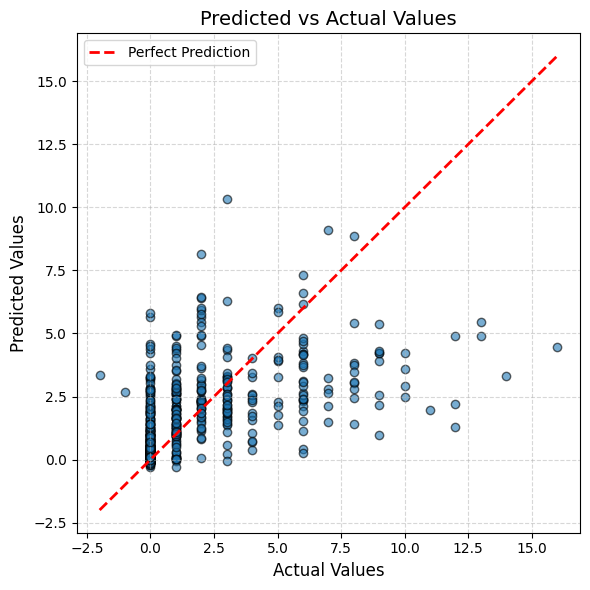

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolor='k')

# Labels and formatting
plt.title("Predicted vs Actual Values", fontsize=14)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)

# Reference line (perfect predictions)
lims = [min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())]
plt.plot(lims, lims, 'r--', lw=2, label='Perfect Prediction')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
test_df['target'].mean()

np.float64(3.4887640449438204)

In [ ]:
results_df.sort_values(by=['gameweek', 'test_rmse'])

,model,gameweek,best_params,test_r2,test_rmse,test_mae,test_mape
18,GradientBoostingRegressor,2,"{'model__learning_rate': 0.01597774786435076, ...",0.520020,3.775499,2.498285,inf
21,XGBRegressor,2,"{'model__learning_rate': 0.016962221594166126,...",0.516104,3.790866,2.478205,inf
15,RandomForestRegressor,2,"{'model__max_depth': 3, 'model__n_estimators':...",0.512819,3.803713,2.510934,inf
27,CatBoostRegressor,2,"{'model__depth': 3, 'model__iterations': 241, ...",0.497553,3.862850,2.564826,inf
24,LGBMRegressor,2,"{'model__learning_rate': 0.045401641878176635,...",0.465591,3.983820,2.557502,inf
12,KNN,2,{'model__n_neighbors': 7},0.449020,4.045114,2.570618,inf
6,Lasso,2,{'model__alpha': 0.10625459084029841},0.174540,4.951201,3.456125,inf
0,ElasticNet,2,"{'model__alpha': 0.10481315701873967, 'model__...",0.173553,4.954160,3.457107,inf
3,Ridge,2,{'model__alpha': 8.565925757139402},0.156211,5.005870,3.458413,inf
9,SVR,2,"{'model__C': 15.925169151603527, 'model__epsil...",-1.340753,8.337588,7.365818,inf


In [ ]:
min_rmse_rows = results_df.loc[results_df.groupby('gameweek')['test_rmse'].idxmin()]
min_rmse_rows['best_params'].iloc[-3]

OrderedDict({'model__learning_rate': 0.01597774786435076, 'model__max_depth': 3, 'model__n_estimators': 228})